In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from PIL import Image 
from torchvision import transforms


In [26]:
gt_path = "/mnt/disk1/mbbank/tien/BBDM/108/test/B/86.npy"
pre_path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/86.npy'



gt_img = np.load(gt_path, allow_pickle=True)

pre_img = np.load(pre_path, allow_pickle=True)

pre_img = pre_img.mean(axis=-1) / 32767.0
gt_img = gt_img/ 32787.0


pre_img.min(), pre_img.max(), gt_img.min(), gt_img.max()

(6.103702e-06, 0.9556278, 0.0, 0.9993900021349925)

In [2]:

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr 
def compute_mae(imgRef, imgT):
    mae = np.sum(np.abs(imgRef - imgT)) / (imgT.size + 1e-7)

    return mae

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [27]:
gt_path = "/mnt/disk1/mbbank/tien/BBDM/108/test/B/86.npy"
pre_path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/86.npy'



gt_img = np.load(gt_path, allow_pickle=True)

pre_img = np.load(pre_path, allow_pickle=True)

pre_img = pre_img.mean(axis=-1) / 32767.0
gt_img = gt_img/ 32767.0
ssim_score = ssim(pre_img, gt_img, data_range=1)
psnr_score = psnr(pre_img, gt_img, data_range=1)
mae = compute_mae(pre_img, gt_img)
print('SSIM: {}'.format(ssim_score))
print('PSNR: {}'.format(psnr_score))
print('mae:{}'.format(mae * 32767.0))

SSIM: 0.9305221606164928
PSNR: 29.14948812435332
mae:330.50661607326856


In [28]:
gt_path = "/mnt/disk1/mbbank/tien/BBDM/108/test/B/86.npy"
pre_path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/86.npy'

gt_img = np.load(gt_path, allow_pickle=True)

pre_img = np.load(pre_path, allow_pickle=True)

pre_img = pre_img.max(axis=-1) / 32767.0
gt_img = gt_img/ 32767.0
ssim_score = ssim(pre_img, gt_img, data_range=1)
psnr_score = psnr(pre_img, gt_img, data_range=1)

print('SSIM: {}'.format(ssim_score))
print('PSNR: {}'.format(psnr_score))

SSIM: 0.9439721925398665
PSNR: 29.0681618142219


In [1]:
# count the number of files in the folder
import os
def count_files(path):
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

count_files('results/108_CT2PET_BBDMxSAG/LBBDM-f4/sample_to_eval/200'),\
    count_files('/mnt/disk1/mbbank/tien/BBDM/108/test/B')

(744, 750)

In [2]:
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Define the function to compute MAE
def compute_mae(image1, image2):
    return np.abs(image1 - image2).mean()

# Paths to the folders
gt_folder = "/mnt/disk1/mbbank/tien/BBDM/108/test/B/"
pre_folder = "results/LBBDMxSAGxVq13_0.3_v_0.5/LBBDM-f4/sample_to_eval/200/"

# Lists to store the computed metrics for each pair
ssim_scores = []
psnr_scores = []
mae_scores = []

# Iterate through the files in the ground truth folder
for filename in os.listdir(gt_folder):
    # Make sure the file is a numpy array
    if filename.endswith(".npy"):
        # Construct the paths for the corresponding ground truth and predicted files
        try:
            gt_path = os.path.join(gt_folder, filename)
            pre_path = os.path.join(pre_folder, filename)
        
            # Load the images as numpy arrays
            gt_img = np.load(gt_path, allow_pickle=True)
            pre_img = np.load(pre_path, allow_pickle=True)
        except:
            continue   
        # Preprocess the predicted image
        pre_img = pre_img.mean(axis=-1) / 32767.0
        
        # Normalize the ground truth image
        gt_img = gt_img / 32767.0
        
        # Calculate the SSIM, PSNR, and MAE for this pair
        ssim_score = ssim(pre_img, gt_img, data_range=1)
        psnr_score = psnr(pre_img, gt_img, data_range=1)
        mae = compute_mae(pre_img, gt_img)
        
        # Append the scores to the corresponding lists
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mae_scores.append(mae * 32767)

# Calculate the mean scores over all pairs
mean_ssim = np.mean(ssim_scores)
mean_psnr = np.mean(psnr_scores)
mean_mae = np.mean(mae_scores)

# Print the mean metrics
print("Mean SSIM: {}".format(mean_ssim))
print("Mean PSNR: {}".format(mean_psnr))
print("Mean MAE: {}".format(mean_mae))


Mean SSIM: 0.959460793901321
Mean PSNR: 31.81860205502502
Mean MAE: 221.01989182245745


In [4]:
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Define the function to compute MAE
def compute_mae(image1, image2):
    return np.abs(image1 - image2).mean()

# Paths to the folders
gt_folder = "/mnt/disk1/mbbank/tien/BBDM/108/test/B/"
pre_folder = "results/LBBDMxSAGxVq13_5.0/LBBDM-f4/sample_to_eval/200/"

# Lists to store the computed metrics for each pair
ssim_scores = []
psnr_scores = []
mae_scores = []

# Iterate through the files in the ground truth folder
for filename in os.listdir(gt_folder):
    # Make sure the file is a numpy array
    if filename.endswith(".npy"):
        # Construct the paths for the corresponding ground truth and predicted files
        try:
            gt_path = os.path.join(gt_folder, filename)
            pre_path = os.path.join(pre_folder, filename)
        
            # Load the images as numpy arrays
            gt_img = np.load(gt_path, allow_pickle=True)
            pre_img = np.load(pre_path, allow_pickle=True)
        except:
            continue   
        # Preprocess the predicted image
        pre_img = pre_img.mean(axis=-1) / 32767.0
        
        # Normalize the ground truth image
        gt_img = gt_img / 32767.0
        
        # Calculate the SSIM, PSNR, and MAE for this pair
        ssim_score = ssim(pre_img, gt_img, data_range=1)
        psnr_score = psnr(pre_img, gt_img, data_range=1)
        mae = compute_mae(pre_img, gt_img)
        
        # Append the scores to the corresponding lists
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mae_scores.append(mae * 32767)

# Calculate the mean scores over all pairs
mean_ssim = np.mean(ssim_scores)
mean_psnr = np.mean(psnr_scores)
mean_mae = np.mean(mae_scores)

# Print the mean metrics
print("Mean SSIM: {}".format(mean_ssim))
print("Mean PSNR: {}".format(mean_psnr))
print("Mean MAE: {}".format(mean_mae))


Mean SSIM: 0.9038721217125889
Mean PSNR: 25.502042904795953
Mean MAE: 496.5157565056596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


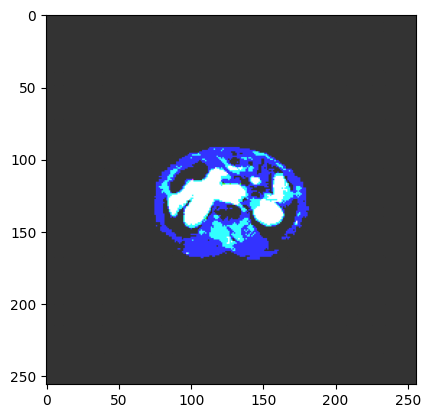

In [42]:
path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/102/output_4.npy'

img_np = np.load(path, allow_pickle=True)
plt.imshow(img_np, )

In [46]:
img_np.min(), img_np.max() 

(0.2, 32767.0)

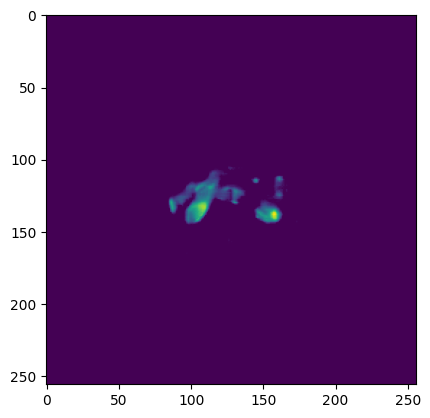

In [40]:
path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/102/output_0.npy'

img = np.load(path, allow_pickle=True)
img = img_np[:, :, 0]
plt.imshow(img)

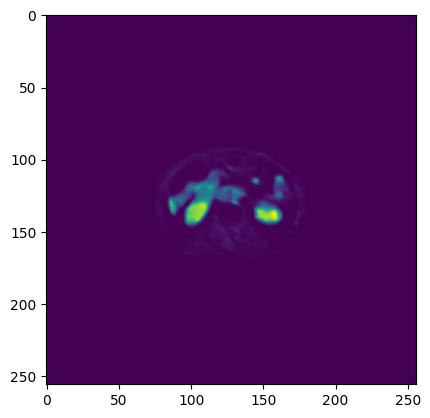

In [41]:
path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200/102/output_0.npy'

img = np.load(path, allow_pickle=True)
img = img_np.mean(axis=-1)
plt.imshow(img)

((256, 256), (256, 256))

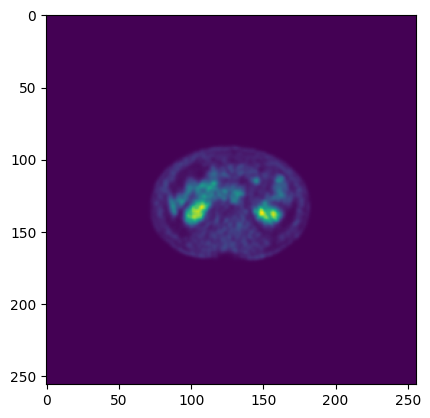

In [44]:
gt_ath = '/mnt/disk1/mbbank/tien/BBDM/108/test/B/102.npy'

gt_img = np.load(gt_ath)

plt.imshow(gt_img)

gt_img.shape, img_np.mean(axis=-1).shape


In [45]:
import os 
import numpy as np
import shutil

parent_path = 'results/108_CT2PET_7_27/LBBDM-f4/sample_to_eval/200'
for path in os.listdir(parent_path):
    
    file_path = os.path.join(parent_path, path, 'output_0.npy')
    np_img = np.load(file_path)
    binary_img = np_img.mean(axis=-1) 
    
    save_path = os.path.join(parent_path, path + '.npy')
    
    
    
    # print(path)
    # break 


1055
